# **Import libraries**

In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import KMeansSMOTE
%matplotlib inline

# **Load Dataset**

In [2]:
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "abcsds/pokemon",
  'Pokemon.csv',
)

Using Colab cache for faster access to the 'pokemon' dataset.


# **Analyse Dataset**

There is no price column. I'll take correlation with Legendary.

In [3]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
df.drop(['#', 'Name'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Type 1      800 non-null    object
 1   Type 2      414 non-null    object
 2   Total       800 non-null    int64 
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(2)
memory usage: 63.4+ KB


In [6]:
df['Legendary'] = df['Legendary'].astype(int)

In [7]:
df.nunique()

,0
Type 1,18
Type 2,18
Total,200
HP,94
Attack,111
Defense,103
Sp. Atk,105
Sp. Def,92
Speed,108
Generation,6


In [8]:
dum_cols = ['Type 1', 'Type 2']

df = pd.get_dummies(df, columns=dum_cols)

In [9]:
df_corr = df.copy()

[]

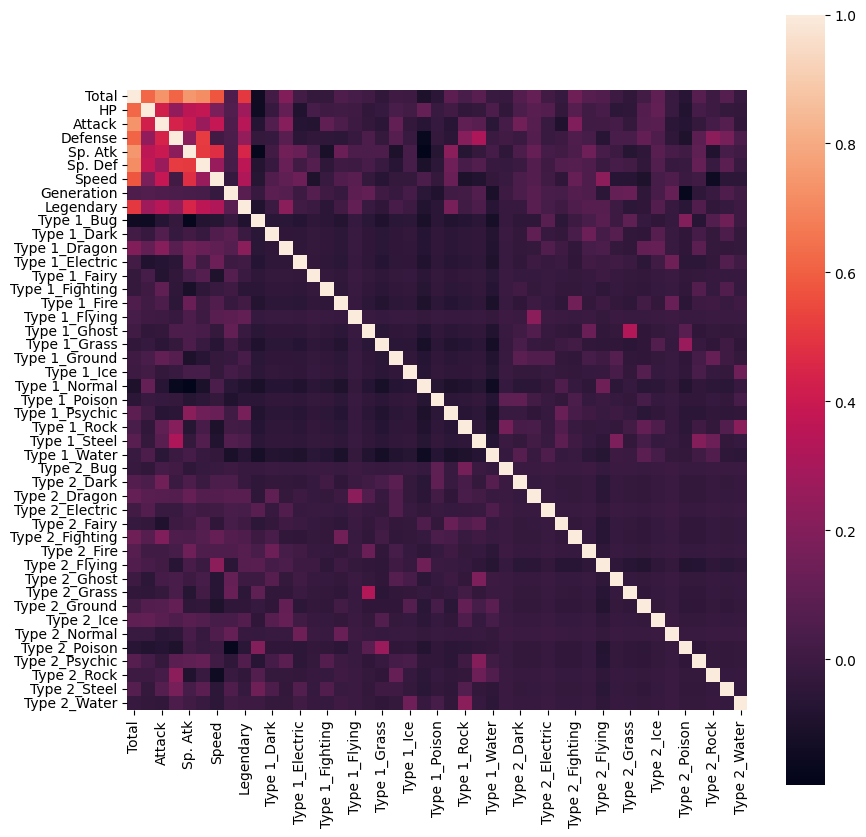

In [10]:
plt.figure(figsize=(10,10))

sns.heatmap(df_corr.corr(), square=True)

plt.plot()

In [11]:
pd.DataFrame(np.abs(df_corr.corr())).sort_values('Legendary', ascending=False)['Legendary'].head()

,Legendary
Legendary,1.000000
Total,0.501758
Sp. Atk,0.448907
Sp. Def,0.363937
Attack,0.345408


Judging by this top, I'll take Total and Sp. Atk.

In [12]:
df_temp = df[['Total', 'Sp. Atk']].copy()

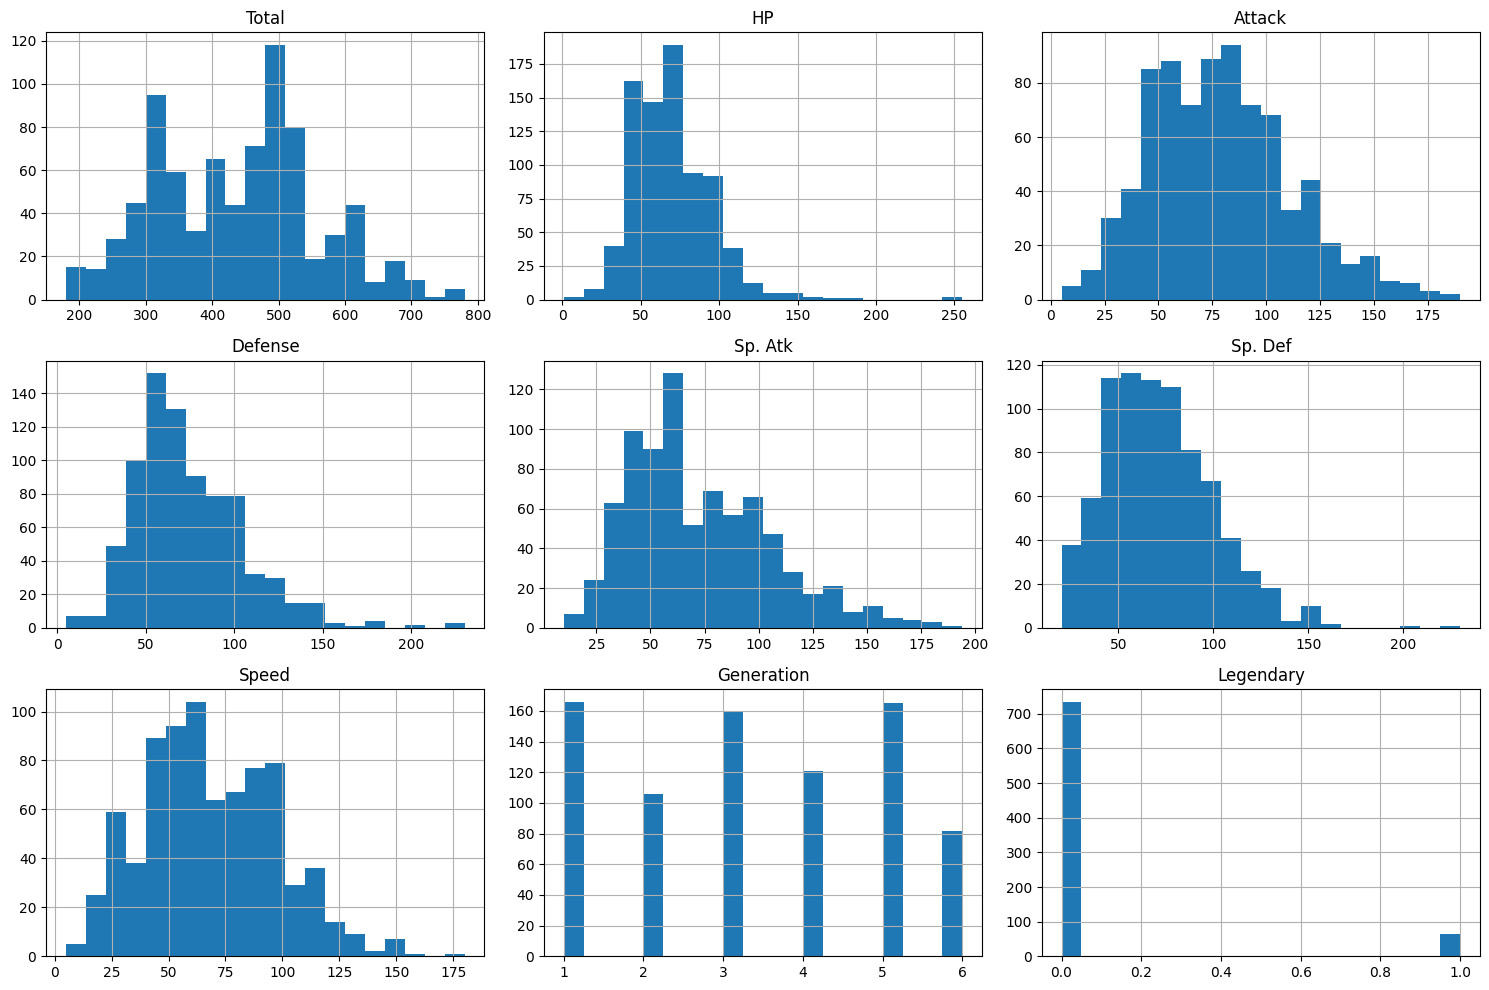

In [13]:
df.hist(bins=20, figsize=(15, 10))

plt.tight_layout()
plt.show()

The majority of columns have skewed data(especially target one, which is obvious as there cannot be many legendary pokemons)

# **Find Outliers**

In [14]:
outlier_models = [
    IsolationForest(random_state=42),
    OneClassSVM(),
    EllipticEnvelope(random_state=42),
    LocalOutlierFactor()
]

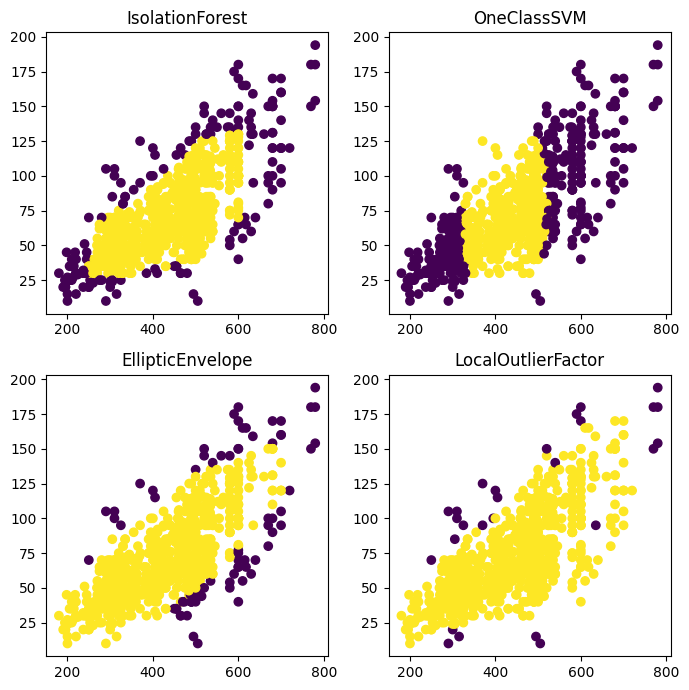

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

for i in range(len(outlier_models)):
    outliers = pd.Series(outlier_models[i].fit_predict(df_temp.values))
    ax = axs[i // 2][i % 2]
    ax.scatter(df_temp['Total'], df_temp['Sp. Atk'], c=outliers, cmap='viridis')
    ax.set_title(type(outlier_models[i]).__name__)

plt.tight_layout()
plt.show()

1. **Isolation Forest**

In the left bottom corner, even though it doesn't really look as an outlier, it is labeled so, because the distribution is skew.

2. **OneClassSVM**

Really bad, it does only count how many they are and how much do they lift the surface.

3. **Elliptic Envelope**

Looks pretty cool, even though some points are mislabeled due to the robust figure.

4. **LocalOutlierFactor**

The best, even though it might have mislabeled one point inside the main mass, as there is a small gap between it and other values.

# **Contamination**

I tried to scale data not to receive warnings, but it didn't work :(

In [16]:
cols_to_scale = ['Sp. Atk', 'Sp. Def', 'Total', 'Speed', 'Defense', 'Attack', 'HP']

df_corr[cols_to_scale] = StandardScaler().fit_transform(df_corr[cols_to_scale])

In [17]:
contaminations = [1e-2, 1e-1, 0.2, 0.4]
outlier_models = [
  IsolationForest,
  EllipticEnvelope,
  LocalOutlierFactor
]
results = []

for m in outlier_models:
    row = []
    for c in contaminations:
        model = m(contamination=c)
        preds = model.fit_predict(df_corr.drop('Legendary', axis=1).values)
        row.append((preds == -1).sum())
    results.append(row)

pd.DataFrame(results,
             index=[m.__name__ for m in outlier_models],
             columns=[f"cont={c}" for c in contaminations])

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


,cont=0.01,cont=0.1,cont=0.2,cont=0.4
IsolationForest,8,80,160,320
EllipticEnvelope,8,80,160,320
LocalOutlierFactor,8,80,160,320


The number of outliers is the same - no surprise, because the contamination parameter determines how many out of all samples will be labeled as outliers.

There is no OneClassSVM, as it doesn't have contamination at all.

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


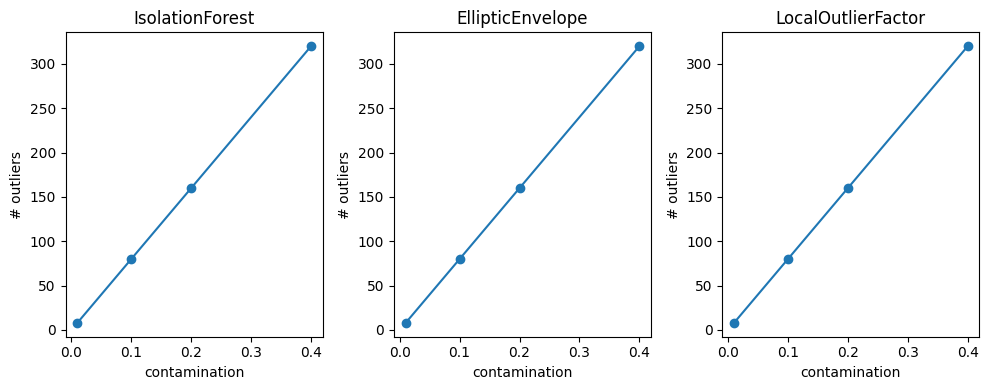

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(10,4))

for i, m in enumerate(outlier_models):
    n_out = []
    for c in contaminations:
        model = m(contamination=c)

        preds = model.fit_predict(df_corr.drop('Legendary', axis=1).values)
        n_out.append((preds == -1).sum())

    ax = axs[i]
    ax.plot(contaminations, n_out, marker='o')
    ax.set_title(m.__name__)
    ax.set_xlabel("contamination")
    ax.set_ylabel("# outliers")

plt.tight_layout()
plt.show()

As I mentioned earlier, doesn't matter which algorithm we use - either way contamination shows the number of outliers from the dataset to be found.

# **Split Dataset**

In [19]:
X = df.drop('Legendary', axis=1)
y = df['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's scale it

In [20]:
std_scaler = StandardScaler()

X_train[cols_to_scale] = std_scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = std_scaler.transform(X_test[cols_to_scale])

In [21]:
outlier_models = [
    IsolationForest(random_state=42),
    OneClassSVM(),
    EllipticEnvelope(random_state=42),
    LocalOutlierFactor()
]

## Subsets

In [22]:
X_trains, y_trains = [X_train], [y_train]

for m in outlier_models:
    preds = m.fit_predict(X_train)
    mask = preds == 1
    X_trains.append(X_train[mask])
    y_trains.append(y_train[mask])

/usr/local/lib/python3.12/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


## Train Models

Because I have binary values, instead of LinearRegression I'll use LogisticRegression and instead of KNN Regressor I'll use KNeighborsClassifier.

In [23]:
names = ['Initial', 'IsolationForest', 'OneClassSVM', 'EllipticEnvelope', 'LocalOutlierFactor']

In [24]:
rows = []
for (i, (X_sub, y_sub)) in enumerate(zip(X_trains, y_trains)):
    lr = LogisticRegression().fit(X_sub, y_sub)
    knn = KNeighborsClassifier().fit(X_sub, y_sub)

    rows.append({
        "model_name": names[i],
        "LogisticRegression": lr.score(X_test, y_test),
        "KNNRClassifier": knn.score(X_test, y_test)
    })

pd.DataFrame(rows)

,model_name,LogisticRegression,KNNRClassifier
0,Initial,0.9625,0.94375
1,IsolationForest,0.9625,0.94375
2,OneClassSVM,0.9500,0.94375
3,EllipticEnvelope,0.9625,0.93750
4,LocalOutlierFactor,0.9625,0.94375


Looks too good. Let's analyse other metrics(f1_score).

In [25]:
df['Legendary'].sum()

np.int64(65)

The data is really skewed - only 65 Legendary Pokemons. So, f1_score will be more informative.

In [26]:
rows = []
for (i, (X_sub, y_sub)) in enumerate(zip(X_trains, y_trains)):
    lr = LogisticRegression().fit(X_sub, y_sub)
    knn = KNeighborsClassifier().fit(X_sub, y_sub)

    rows.append({
        "model_name": names[i],
        "LogisticRegression": f1_score(y_test, lr.predict(X_test)),
        "KNNRClassifier": f1_score(y_test, knn.predict(X_test))
    })

pd.DataFrame(rows)

,model_name,LogisticRegression,KNNRClassifier
0,Initial,0.750000,0.571429
1,IsolationForest,0.750000,0.571429
2,OneClassSVM,0.636364,0.181818
3,EllipticEnvelope,0.750000,0.500000
4,LocalOutlierFactor,0.750000,0.571429


Now we see something more realistic.

For Logistic Regression, the majority of algorithms have found outliers that weren't reflected in the model performance. However, OneClassSVM has performed a little bit worse.

KNNClassifier was overall not that good, but with OneClassSVM it became really bad. because the accuracy is pretty high, I suppose it just gives not Legendary to almost all samples - most probably, OneClassSVM deleted some Legendary samples(because they tend to be overperforming others and may look like outliers). EllipticEnvelope has cause a slight decrease of f1_score - the shape is too rough and has also detected some valuable samples for KNN's distance-based decision process.

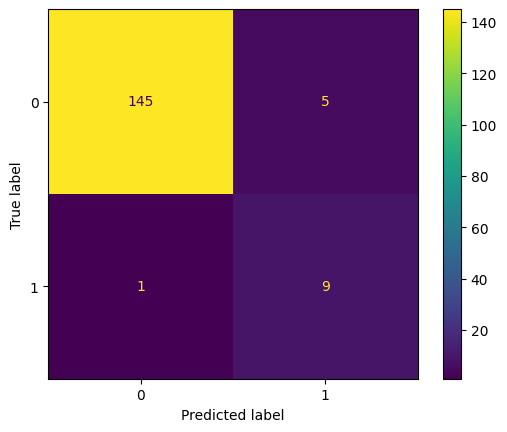

In [27]:
model = LogisticRegression()

model.fit(X_trains[4], y_trains[4])
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm
)

disp.plot()
plt.show()

Judging by this matrix, the results are pretty good - almost all pokemons were labeled correctly, except 6, with only 1 legendary missed.

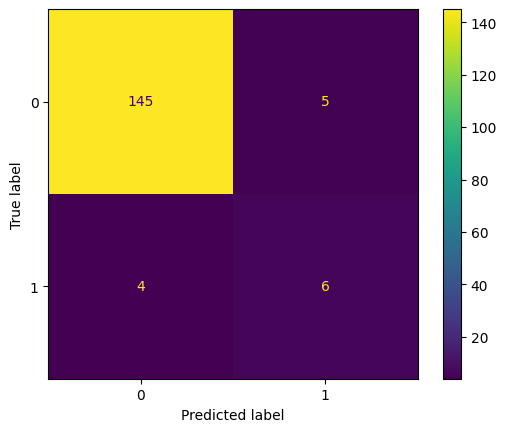

In [28]:
model = KNeighborsClassifier()

model.fit(X_trains[4], y_trains[4])
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm
)

disp.plot()
plt.show()

The majority of simple pokemons were found, but even though it is bad as the legendary ones are terribly missed.

**Initial**

In [29]:
pd.concat([X_trains[0], y_trains[0]], axis=1).describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,640.000000,6.400000e+02,6.400000e+02,6.400000e+02,6.400000e+02,6.400000e+02,640.000000,640.000000,640.000000
mean,0.000000,1.360023e-16,1.720846e-16,1.748601e-16,9.922618e-17,-9.089951e-17,0.000000,3.303125,0.085938
std,1.000782,1.000782e+00,1.000782e+00,1.000782e+00,1.000782e+00,1.000782e+00,1.000782,1.651667,0.280491
min,-2.098627,-2.296306e+00,-2.289679e+00,-2.156875e+00,-1.929271e+00,-1.837093e+00,-2.166962,1.000000,0.000000
25%,-0.863301,-7.508259e-01,-7.427292e-01,-7.250569e-01,-7.570162e-01,-7.568803e-01,-0.798242,2.000000,0.000000
50%,0.060598,-1.712706e-01,-1.239493e-01,-8.869319e-02,-2.213503e-01,-1.987704e-01,-0.113882,3.000000,0.000000
75%,0.641928,4.082846e-01,6.495255e-01,5.476705e-01,7.102425e-01,6.473962e-01,0.741568,5.000000,0.000000
max,2.884201,7.169762e+00,3.434035e+00,5.002217e+00,3.784499e+00,5.724396e+00,3.821189,6.000000,1.000000


**IsolationForest**

As we see, IsolationForest has its performance due to the fact it hadn't found any outliers - the number of entries is the same as in initial one.

In [30]:
pd.concat([X_trains[1], y_trains[1]], axis=1).describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,640.000000,6.400000e+02,6.400000e+02,6.400000e+02,6.400000e+02,6.400000e+02,640.000000,640.000000,640.000000
mean,0.000000,1.360023e-16,1.720846e-16,1.748601e-16,9.922618e-17,-9.089951e-17,0.000000,3.303125,0.085938
std,1.000782,1.000782e+00,1.000782e+00,1.000782e+00,1.000782e+00,1.000782e+00,1.000782,1.651667,0.280491
min,-2.098627,-2.296306e+00,-2.289679e+00,-2.156875e+00,-1.929271e+00,-1.837093e+00,-2.166962,1.000000,0.000000
25%,-0.863301,-7.508259e-01,-7.427292e-01,-7.250569e-01,-7.570162e-01,-7.568803e-01,-0.798242,2.000000,0.000000
50%,0.060598,-1.712706e-01,-1.239493e-01,-8.869319e-02,-2.213503e-01,-1.987704e-01,-0.113882,3.000000,0.000000
75%,0.641928,4.082846e-01,6.495255e-01,5.476705e-01,7.102425e-01,6.473962e-01,0.741568,5.000000,0.000000
max,2.884201,7.169762e+00,3.434035e+00,5.002217e+00,3.784499e+00,5.724396e+00,3.821189,6.000000,1.000000


**OneClassSVM**

It has deleted a quite large number of samples(as in 2D we saw before). But, as we see from the mean of Legendary, it has deleted a larger amount of Legendary samples - the data became even more skewed.

In [31]:
pd.concat([X_trains[2], y_trains[2]], axis=1).describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,-0.115446,-0.083305,-0.043099,-0.144725,-0.070870,-0.118830,-0.007569,3.342767,0.018868
std,0.685186,0.674992,0.718212,0.665132,0.710156,0.710283,0.766509,1.338154,0.136273
min,-1.517297,-1.523566,-1.670899,-1.361421,-1.308209,-1.477022,-1.311512,1.000000,0.000000
25%,-0.769873,-0.557641,-0.588034,-0.717102,-0.663857,-0.648859,-0.627152,2.000000,0.000000
50%,-0.105496,-0.171271,-0.108480,-0.247784,-0.221350,-0.216774,-0.113882,3.000000,0.000000
75%,0.434311,0.292374,0.494831,0.229489,0.423001,0.323332,0.570478,4.750000,0.000000
max,1.389353,1.760580,1.732390,1.820398,1.797101,1.943651,1.939199,6.000000,1.000000


**EllipticEnvelope**

As we see, it also deleted a larger number of Legendary samples(but nor as much as SVM, hopefully).

In [32]:
pd.concat([X_trains[3], y_trains[3]], axis=1).describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,-0.053937,-0.052945,-0.012923,-0.083059,-0.037296,-0.046553,0.013604,3.239583,0.072917
std,0.988477,0.884644,0.981489,0.889455,0.963842,0.956664,1.007263,1.623168,0.260226
min,-2.098627,-2.296306,-2.289679,-2.156875,-1.929271,-1.837093,-2.166962,1.000000,0.000000
25%,-0.935967,-0.750826,-0.742729,-0.725057,-0.842412,-0.756880,-0.798242,2.000000,0.000000
50%,-0.051515,-0.171271,-0.123949,-0.184148,-0.221350,-0.216774,-0.113882,3.000000,0.000000
75%,0.558881,0.408285,0.649525,0.420398,0.655900,0.503368,0.741568,5.000000,0.000000
max,2.884201,3.885616,3.434035,4.047671,3.784499,4.644183,3.821189,6.000000,1.000000


**LocalOutlierFactor**

It has deleted a really small proportion of samples, almost preserving the weight of Legendary - that's why it's performance was still the same as of initial one.

In [33]:
pd.concat([X_trains[4], y_trains[4]], axis=1).describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,-0.004401,-0.025424,0.007651,0.002051,0.001352,-0.010938,0.002621,3.313386,0.085039
std,1.002229,0.900052,0.983952,0.975480,0.990684,0.970184,0.993216,1.653138,0.279160
min,-2.098627,-2.296306,-2.289679,-2.156875,-1.929271,-1.837093,-2.166962,1.000000,0.000000
25%,-0.869529,-0.750826,-0.742729,-0.725057,-0.749253,-0.756880,-0.798242,2.000000,0.000000
50%,0.060598,-0.171271,-0.123949,-0.088693,-0.221350,-0.216774,-0.113882,3.000000,0.000000
75%,0.641928,0.408285,0.649525,0.547671,0.710243,0.593386,0.741568,5.000000,0.000000
max,2.884201,3.885616,3.434035,5.002217,3.784499,4.644183,3.821189,6.000000,1.000000


# **Conclusion?**

Overall, each algorithm has its own way of detecting outliers, and each can be preferred in different situations. In this case, the best is LocalOutlierFactor, which worked as well as the initial data for LogisticRegression and KNNClassifier.

# **Post Scriptum**

But still, I want to try to enhance the results!

As we deal with highly skew data, let's use SMOTE for oversampling.

I'll use KMeansSMOTE because I have KNNClassifier, which works with distances too (I tried others, they gave poor results)

In [34]:
for i, (X_train, y_train) in enumerate(zip(X_trains, y_trains)):
  sm = KMeansSMOTE(cluster_balance_threshold=0.14,random_state=42)
  X_trains[i], y_trains[i] = sm.fit_resample(X_train, y_train)

In [35]:
rows = []
for (i, (X_sub, y_sub)) in enumerate(zip(X_trains, y_trains)):
    lr = LogisticRegression().fit(X_sub, y_sub)
    knn = KNeighborsClassifier().fit(X_sub, y_sub)

    rows.append({
        "model_name": names[i],
        "LogisticRegression": lr.score(X_test, y_test),
        "KNNRClassifier": knn.score(X_test, y_test)
    })

pd.DataFrame(rows)

,model_name,LogisticRegression,KNNRClassifier
0,Initial,0.93125,0.93125
1,IsolationForest,0.93125,0.93125
2,OneClassSVM,0.93125,0.94375
3,EllipticEnvelope,0.93125,0.94375
4,LocalOutlierFactor,0.95000,0.94375


In [36]:
rows = []
for (i, (X_sub, y_sub)) in enumerate(zip(X_trains, y_trains)):
    lr = LogisticRegression().fit(X_sub, y_sub)
    knn = KNeighborsClassifier().fit(X_sub, y_sub)

    rows.append({
        "model_name": names[i],
        "LogisticRegression": f1_score(y_test, lr.predict(X_test)),
        "KNNRClassifier": f1_score(y_test, knn.predict(X_test))
    })

pd.DataFrame(rows)

,model_name,LogisticRegression,KNNRClassifier
0,Initial,0.620690,0.592593
1,IsolationForest,0.620690,0.592593
2,OneClassSVM,0.592593,0.526316
3,EllipticEnvelope,0.592593,0.640000
4,LocalOutlierFactor,0.714286,0.640000


Actually, the performance of LogisticRegression dropped(most probably because SMOTE distorted the weights of LinearRegression).

But, the performance of KNNClassifier has increased a lot! Especially EllipticEnvelope and LocalOutlierFactor - they might have kept some valuable samples which helped to create meaningful clusters.

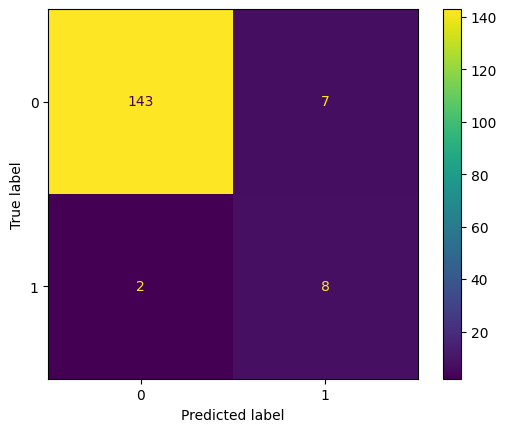

In [37]:
model = KNeighborsClassifier()

model.fit(X_trains[4], y_trains[4])
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm
)

disp.plot()
plt.show()

Overall, the confusion matrix shows that the majority of both classes were found correctly, with only 2 legendary pokemons missed and 7 mismatched. A little better than before SMOTE.

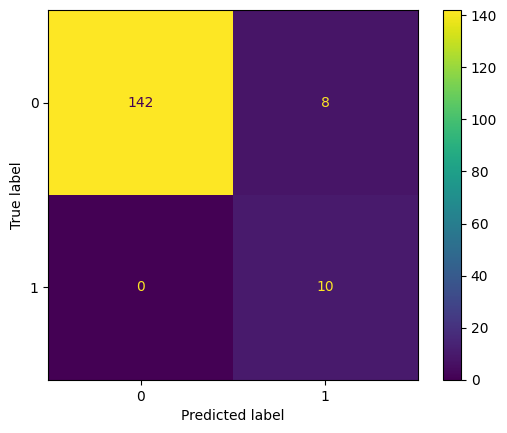

In [38]:
model = LogisticRegression()

model.fit(X_trains[4], y_trains[4])
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm
)

disp.plot()
plt.show()

Actually, it is not that bad - SMOTE helped LogisticRegression find all the legendary pokemons, but it mismatched some simple ones. If we really value the true positives/falsse positives, it is great.